_This notebook was put together by [Keneth Garcia](https://stivengarcia7113.wixsite.com/kenethgarcia). Source and license info are on [GitHub](https://github.com/KenethGarcia/GRB_ML)._

# Swift Data Interpolation
The Neil Gehrels Swift Observatory presents analysis results for the Swift/BAT Gamma-Ray Burst (GRBs) on [this website](https://swift.gsfc.nasa.gov/results/batgrbcat/) (open access).

In previous notebooks, we used the 64ms data from Swift and added an option to use more resolutions and data with a high signal-to-noise ratio. Unfortunately, the high signal-to-noise ratio data doesn't have a uniform separation in its points, therefore, we can't properly implement the pre-processing step (e.g., it isn't possible to standardize the time basis for all GRBs simultaneously). To solve this problem, the fastest method is to interpolate between data points in each light curve. This notebook summarizes how to do this job in an intuitive way, through this document, we are using the _python3_ implementations from the _scripts_ folder. It is necessary to have a _Jupyter Notebook_/_Python 3_ compiler software.

First, we need to import the **main.py** file to our notebook (and some packages needed):

In [21]:
from scripts import main
from prettytable import PrettyTable  # Import module to do tables
import os  # Import os to handle folders and files
import numpy as np  # Import numpy module to read tables, manage data, etc

Then, create a new object from the `main.py` class and, if you need, set the data, table and results folder paths (by default it will be the "Data", "Table", and "Results" folders inside the path containing this notebook):

In [22]:
%matplotlib inline
object1 = main.SwiftGRBWorker()
object1.original_data_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Data\Original_Data'  # Change original data path
object1.table_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Tables'  # Change table path
object1.results_path = r'G:\Mi unidad\Cursos\Master_Degree_Project\GRB_ML\Results'  # Change results path

## Changing the Swift GRB binning
By default, this notebook interpolates the data for high signal-to-noise ratio in Swift. There are some cases in which we need to use different data resolutions and binning; handling these situations can be solved in this package by managing the _resolution_ and _end_ variables.

Through this package, you can change the _resolution_ variable to $2$, $8$, $16$, $64$, and $256$ ms respectively. Additionally, you can set $1$ for 1s binning and change the end variable to "sn5_10s" to use data with a signal-to-noise ratio higher than 5 or 10 s binning (these data don't have uniform time spacing).

In [23]:
# object1.res = 64  # Resolution for the Light Curve Data in ms, could be 2, 8, 16, 64 (default), 256 and 1 (this last in s)
object1.end = "sn5_10s"  # Uncomment this line if you need to use signal-to-noise higher than 5 or 10s binning

It is advisable not to change both variables at the same time; this could cause unknown bugs when running package routines and sub-routines. Additionally, you will need the data downloaded for the selected binning.

Last, from the download section, extract the GRB Names filtered by download error:

In [24]:
sum_general_path = os.path.join(object1.table_path, "summary_general.txt")  # Path to summary table
GRB_names, ids = np.genfromtxt(sum_general_path, delimiter="|", dtype=str, usecols=(0, 1), unpack=True, autostrip=True)  # GRB Names total array
GRB_errors = np.genfromtxt(os.path.join(object1.original_data_path, f"Errors_{object1.end}.txt"), delimiter='|', dtype=str, unpack=True)[0]
non_common = np.where(np.isin(GRB_names, GRB_errors, invert=True))[0]
GRB_names = GRB_names[non_common]

If you haven't downloaded the data yet, check the _Swift_Data_Download_ notebook.

## Interpolation
First, consider the example GRB graph with a high signal-to-noise ratio:

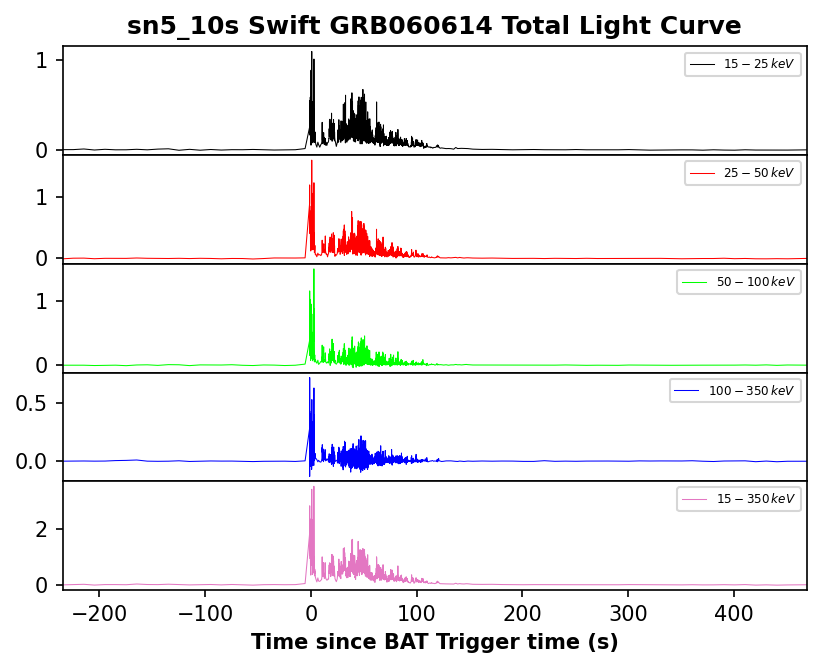

In [25]:
name = 'GRB060614'  # Change this name if you want another GRB
fig = object1.plot_any_grb(name, t=False)

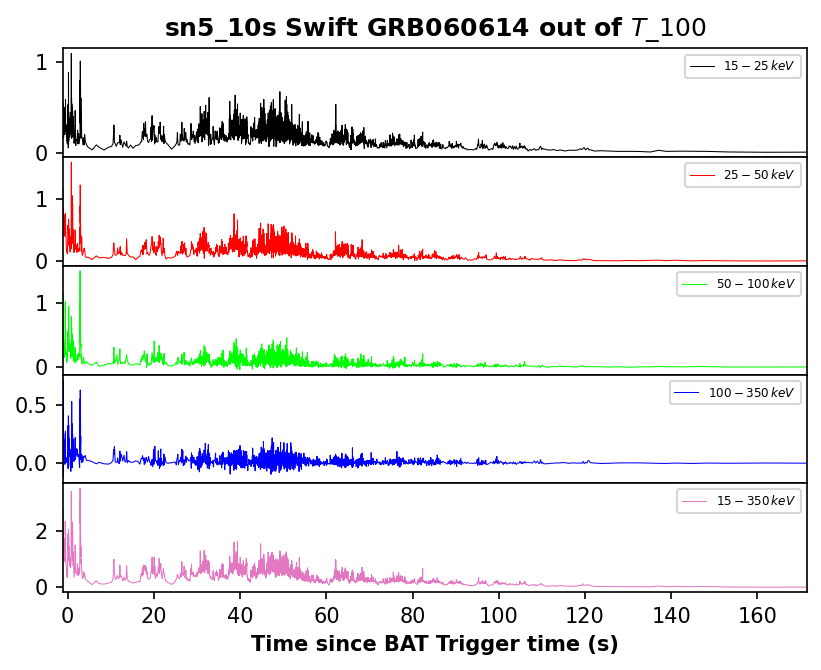

In [26]:
fig_2 = object1.plot_any_grb(name, t=100)

To interpolate this light curve, we need to take each band and fit a polynomial function. The `one_grb_interpolate` instance takes an argument called 'kind' to select the polynomial order, namely:
* 'linear' to use 1-order polynomial
* 'quadratic' to use 2-order polynomial
* 'cubic' to use 3-order polynomial

There are more types of 'kind' arguments; you can check more info at [this link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html).

Let's see what happens when we use interpolate with kind='linear' between $T_{100}$:

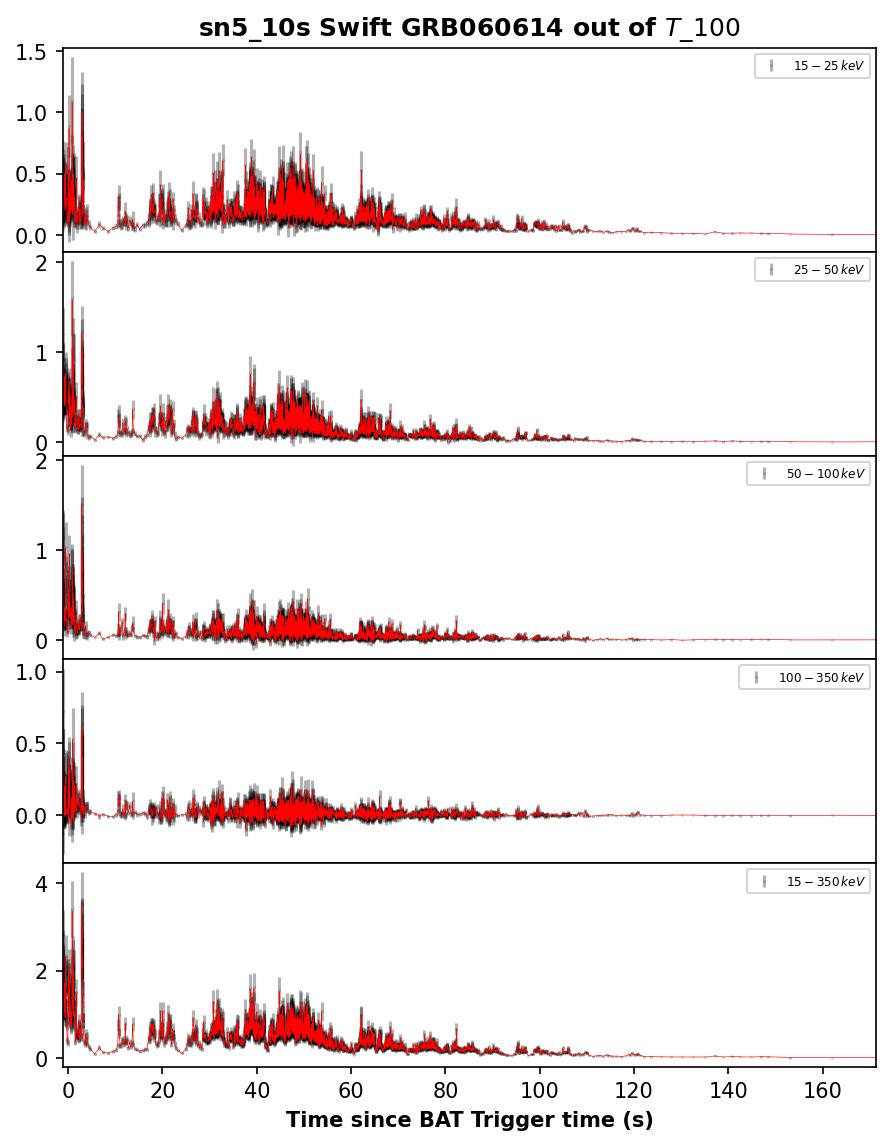

In [27]:
new_data_2, fig_3 = object1.one_grb_interpolate(name, resolution=1, kind='linear', plot=True, t=100, save_fig=False)

As you can see, the interpolation results are acceptable compared with the data. The `one_grb_interpolate` instance additionally receives the GRB_name (_name_), spacing resolution of interpolating data in milliseconds (_resolution_), light curve limiting intervals (_t, limits_), plotting arguments (_plot, save_fig_), and grouping data info (pack_num, we are taking this parameter in the next section).

## Number of data grouped per interpolation
The last section introduces the interpolation instance using only  kind='linear'. Take the interpolation carefully when you use 2nd or 3rd order polynomial because it can return negative count values.

To resolve this problem, we need to understand how `one_grb_interpolate` works: First, it takes each GRB band and separates them into n arrays of length _pack_num_ (default=10). Then it interpolates each array using a polynomial of degree n (depending on kind value). The value of _pack_num_ plays a significant role when you use high order polynomial. Lower _pack_num_ improves the result but takes higher execution time.

Consider using a cubic interpolation for the example GRB:

CPU times: total: 5.56 s
Wall time: 6.05 s


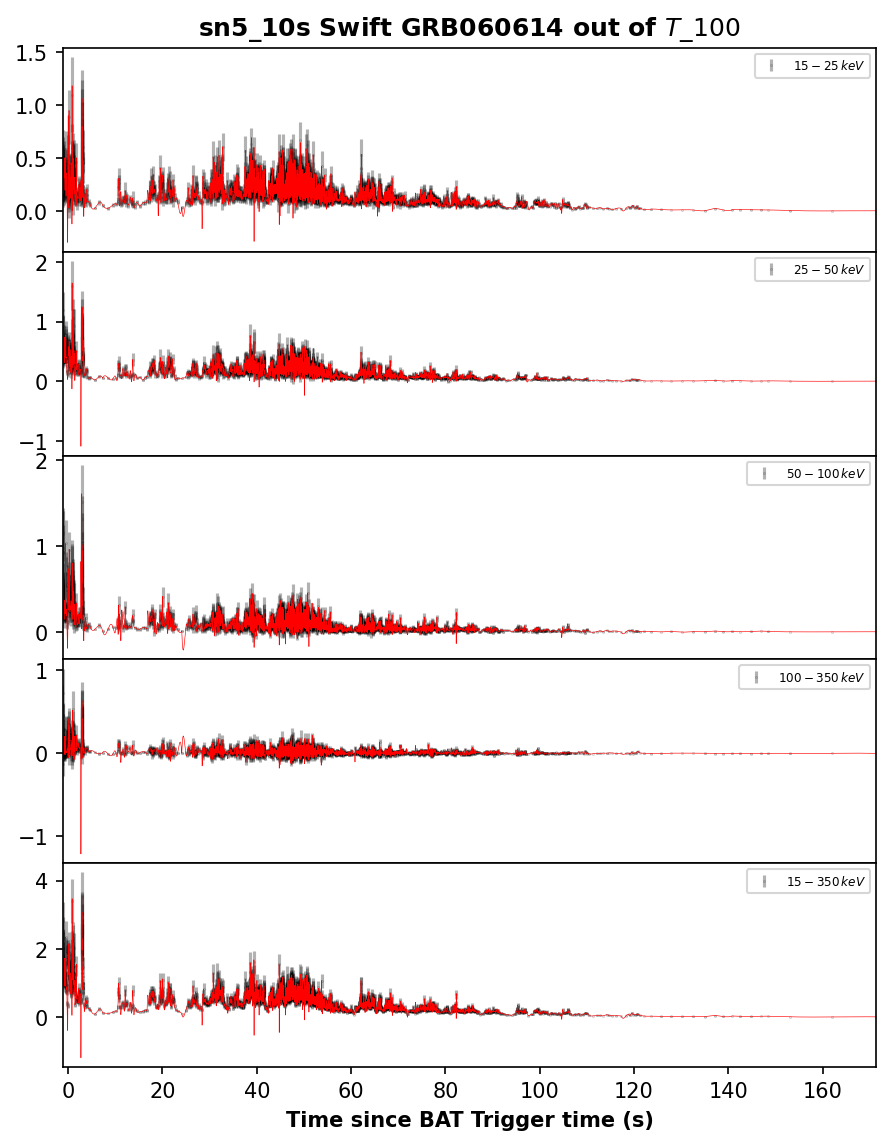

In [28]:
%time new_data_3, fig_4 = object1.one_grb_interpolate(name, resolution=1, kind='cubic', plot=True, t=100, save_fig=False)

As expected, there are regions where the interpolation returns clearly wrong negative values. Now, using the lowest _pack_num_ = 2:

CPU times: total: 15.7 s
Wall time: 16.1 s


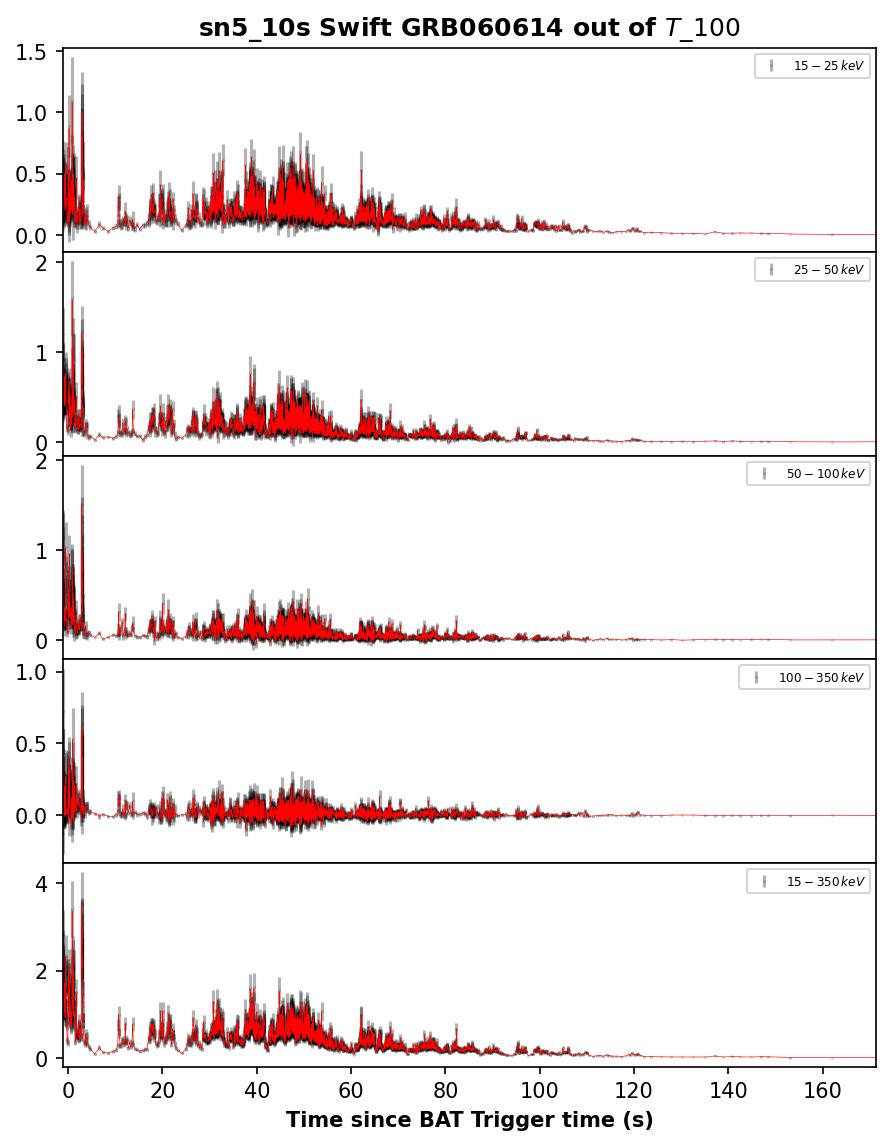

In [29]:
%time new_data_4, fig_5 = object1.one_grb_interpolate(name, resolution=1, kind='cubic', plot=True, t=100, pack_num=2, save_fig=False)

The result interpolation improves a lot compared with the last case! The _pack_num_ value depends on how you want to sacrifice time execution with interpolation accuracy (Remember, only for high order polynomial).

**WARNING:** When _interp1d_ instance of scipy fails, it sets by default _kind_ = 'linear. This is specially important in redundant cases, for example _pack_num_ $< 2$ when _kind_ = 'cubic' (cubic interpolation isn't possible with 2 points).

## Pre-processing interpolated data
The next step is to interpolate all GRBs and pre-process them using the same rules as in _Data_Preprocessing_ notebook. However, we can limit all light curves and interpolate them using the `so_much_interpolate` instance with t=100:

In [30]:
interpolated_data, GRB_names, errors = object1.so_much_interpolate(GRB_names[:2], resolution=1, t=100, plot=False, save_fig=False)
print(f"{len(interpolated_data)} GRBs limited ({len(errors)} Errors)")
y = PrettyTable()  # Create printable table
column_names_2 = ('Name', 't_start', 't_end', 'Error Type')
[y.add_column(column_names_2[i], errors[:, i]) for i in range(len(errors[0]))]  # Add rows to each column
print(y)

LC Interpolating:   0%|          | 0/100 [00:04<?, ?GRB/s]


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

and save them in the results folder:

In [ ]:
object1.save_data(f"Interpolated_data_{object1.end}", names=GRB_names, data=interpolated_data)  # Save Interpolated Data

Now, we pass to normalize:

In [ ]:
normalized_data = object1.so_much_normalize(interpolated_data)  # Normalizing all light curves

to zero-pad:

In [ ]:
object1.res = 64
zero_padded_data = object1.so_much_zero_pad(normalized_data)

and to perform DFT:

In [ ]:
pre_processing_data = object1.so_much_fourier(zero_padded_data)

Finally, we save the results:

In [ ]:
object1.save_data(f"DFT_Interpolated_data_{object1.end}", names=GRB_names, data=pre_processing_data)  # Save Data with DFT